# Coregistered stack of SLCs with topsStack

In [1]:
# Import required packages
import os
import sys
#import asf_search as asf
import logging
import isce
root_logger = logging.getLogger()
root_logger.setLevel('WARNING')
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal
from datetime import datetime, timedelta
import time
from glob import glob
import asf_search as asf

## Coregister stack of SLCs

In [2]:
# Set environment variables to call ISCE from the command line
os.environ['ISCE_HOME'] = os.path.dirname(isce.__file__)
os.environ['ISCE_ROOT'] = os.path.dirname(os.environ['ISCE_HOME'])
os.environ['ISCE_STACK'] = '/mnt/Backups/gbrench/sw/insar_tools/isce2/src/isce2/contrib/stack'
os.environ['PYTHONPATH'] = os.environ['ISCE_STACK']
os.environ['PATH'] += f":{os.environ['ISCE_STACK']}/topsStack"

In [3]:
scene_list=[
'S1A_IW_SLC__1SDV_20191004T121345_20191004T121412_029309_0354B0_F48E',
'S1A_IW_SLC__1SDV_20191016T121345_20191016T121412_029484_035ABB_373F',
'S1A_IW_SLC__1SDV_20191028T121345_20191028T121412_029659_0360C3_574E',
'S1A_IW_SLC__1SDV_20191109T121345_20191109T121412_029834_0366F3_462C',
'S1A_IW_SLC__1SDV_20191121T121344_20191121T121411_030009_036CFD_787C',
'S1A_IW_SLC__1SDV_20191203T121344_20191203T121411_030184_03730F_4C1A',
'S1A_IW_SLC__1SDV_20191215T121344_20191215T121411_030359_03791A_4B57',
'S1A_IW_SLC__1SDV_20191227T121343_20191227T121410_030534_037F23_3C47',
'S1A_IW_SLC__1SDV_20200108T121343_20200108T121410_030709_038533_C53D',
'S1A_IW_SLC__1SDV_20200120T121342_20200120T121409_030884_038B59_8828',
'S1A_IW_SLC__1SDV_20200201T121342_20200201T121409_031059_039174_1908',
'S1A_IW_SLC__1SDV_20200213T121341_20200213T121408_031234_039785_41EB',
'S1A_IW_SLC__1SDV_20200225T121341_20200225T121408_031409_039D91_8F87',
'S1A_IW_SLC__1SDV_20200308T121341_20200308T121408_031584_03A39B_6624',
'S1A_IW_SLC__1SDV_20200320T121342_20200320T121409_031759_03A9BC_08F7',
'S1A_IW_SLC__1SDV_20200401T121342_20200401T121409_031934_03AFE6_E721',
'S1A_IW_SLC__1SDV_20200413T121342_20200413T121409_032109_03B610_2EA6',
'S1A_IW_SLC__1SDV_20200425T121343_20200425T121410_032284_03BC35_898C'
           ]

In [4]:
proc_path = '/mnt/Backups/gbrench/repos/fusits/nbs/imja/agu_push/AT12'

In [ ]:
# download slcs
results = asf.granule_search(scene_list)
results.download(path=f'{proc_path}/slc', processes=2)

In [ ]:
# download dem
os.chdir(f'{proc_path}/dem')
!sardem --bbox 85.9 27.1 87.6 28.6 --xrate 3 --yrate 3 --data-source COP -isce

In [ ]:
# stacksentinel to generate run files
os.chdir(proc_path)
!stackSentinel.py -s ./slc -o ./orbits -a ./aux -d ./dem/elevation.dem -w ./work -C geometry --bbox '27.3 28.3 86.1 87.4' -W slc -C geometry --num_proc 2

In [ ]:
%%time
!sh ./work/run_files/run_01_unpack_topo_reference

In [ ]:
%%time
!sh ./work/run_files/run_02_unpack_secondary_slc

In [ ]:
%%time
!sh ./work/run_files/run_03_average_baseline

In [ ]:
%%time
!sh ./work/run_files/run_04_fullBurst_geo2rdr

In [ ]:
%%time
!sh ./work/run_files/run_05_fullBurst_resample

In [ ]:
%%time
!sh ./work/run_files/run_06_extract_stack_valid_region

In [ ]:
%%time
!sh ./work/run_files/run_07_merge_reference_secondary_slc

In [ ]:
%%time
!sh ./work/run_files/run_08_grid_baseline

In [5]:
# examine slcs
fn = '/mnt/Backups/gbrench/repos/fusits/nbs/imja/agu_push/AT12/work/merged/SLC/20191004/20191004.slc.full'
def plotcomplexdata(GDALfilename,
                    aspect=1,
                    datamin=None, datamax=None,
                    interpolation='nearest',
                    draw_colorbar=None, colorbar_orientation="horizontal"):
    # Load the data into numpy array
    ds = gdal.Open(GDALfilename, gdal.GA_ReadOnly)
    slc = ds.GetRasterBand(1).ReadAsArray()
    transform = ds.GetGeoTransform()
    ds = None
    
    # getting the min max of the axes
    firstx = transform[0]
    firsty = transform[3]
    deltay = transform[5]
    deltax = transform[1]
    lastx = firstx+slc.shape[1]*deltax
    lasty = firsty+slc.shape[0]*deltay
    ymin = np.min([lasty,firsty])
    ymax = np.max([lasty,firsty])
    xmin = np.min([lastx,firstx])
    xmax = np.max([lastx,firstx])

    # put all zero values to nan and do not plot nan
    try:
        slc[slc==0]=np.nan
    except:
        pass

    
    f, ax = plt.subplots(2, 1, figsize=(10, 8))
    cax1=ax[0].imshow(np.abs(slc), vmin = datamin, vmax=datamax,
                   cmap='Greys_r', extent=[xmin,xmax,ymin,ymax],
                   interpolation=interpolation)
    ax[0].set_title('amplitude')
    if draw_colorbar is not None:
        cbar1 = f.colorbar(cax1, shrink=0.4)
    ax[0].set_aspect(aspect)

    cax2 =ax[1].imshow(np.angle(slc), cmap='rainbow',
                    vmin=-np.pi, vmax=np.pi,
                    extent=[xmin,xmax,ymin,ymax],
                    interpolation=interpolation)
    ax[1].set_title('phase [rad])')
    if draw_colorbar is not None:
        cbar2 = f.colorbar(cax2, shrink=0.4)
    ax[1].set_aspect(aspect)
    f.tight_layout()
    
    # clearing the data
    slc = None

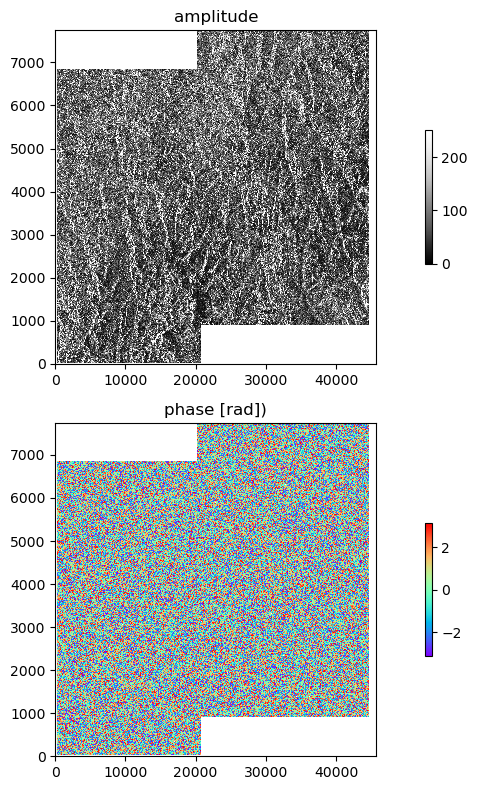

In [7]:
plotcomplexdata(fn, datamin=0, datamax=250, draw_colorbar=True, aspect=6.13)